In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read in previously processed data (see other notebook).

In [4]:
data = pd.read_csv('/content/drive/MyDrive/UW/HonorsTango/acc.csv')

In [5]:
data

,Acc_X_lf,Acc_Y_lf,Acc_Z_lf,Acc_X_rf,Acc_Y_rf,Acc_Z_rf
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,9.758830,0.927461,-0.714978,9.699115,-0.513605,-0.380895
2,9.756316,0.915218,-0.730104,9.798959,-0.638377,-0.403752
3,9.770414,0.887853,-0.730982,9.759178,-0.524447,-0.082214
4,9.760866,0.828819,-0.739239,9.763987,-0.302779,0.094322
...,...,...,...,...,...,...
11326,9.753215,1.134743,-0.775118,9.589693,-1.819086,-0.704415
11327,9.721666,1.182624,-0.775821,9.598711,-1.754096,-0.696568
11328,9.703089,1.149297,-0.768051,9.540620,-1.777237,-0.630781
11329,9.686001,1.175226,-0.748667,9.546093,-1.797369,-0.685272


Work on only a subset of the data for now, and only with two columns, so the cluster is easier and makes more sense.

In [29]:
subset = data.iloc[5000:6000, [0,3]]

#### Use a method to find the distance metric and link method that gives the most cophenet variance.

In [9]:
def find_clustering(df, dist = ['euclidean', 'chebyshev', 'mahalanobis'], link = ['single', 'complete', 'average']):
  c_max = -float('inf')

  for i in dist:
    for j in link:

      z = linkage(df, metric = i, method = j)
      c, c_dist = cophenet(z, pdist(df))
      print(c)
      if c > c_max:
        c_max = c
        idx_max = (i,j)

  print('c_max:', c_max)
  print('idx_max:', idx_max)
  return c_max, idx_max

In [10]:
c_max, idx_max = find_clustering(subset)

0.7679068553170383
0.5186589443880927
0.8012805547896571
0.7537715390770586
0.7125966372746867
0.8184214568514522
0.7643477799213941
0.6872724670967465
0.8091295402491832
c_max: 0.8184214568514522
idx_max: ('chebyshev', 'average')


From the output, Chebyshev's distance and average linkage gives the most cophenet variance.

In [11]:
subset

,Acc_X_lf,Acc_X_rf
5000,7.888423,9.925279
5001,7.676046,9.915658
5002,7.637376,9.691673
5003,7.622686,9.520134
5004,7.669036,9.432447
...,...,...
5995,9.050913,9.424155
5996,9.085819,9.341519
5997,9.252160,9.423515
5998,9.261252,10.128176


In [26]:
z = linkage(subset, metric = idx_max[0], method = idx_max[1])

Plot the dendrogram of the linkage with the distance metric and the linkage method that gives the most cophenet variance.

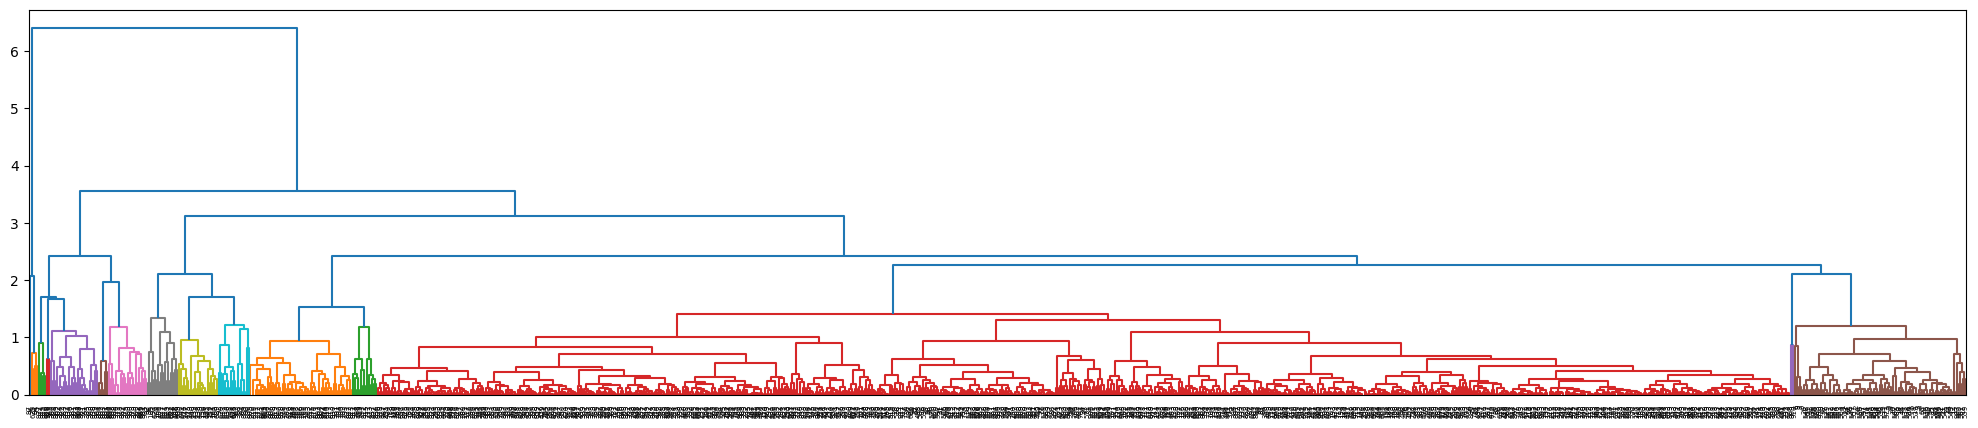

In [27]:
plt.figure(figsize = (25, 5))
dendrogram(z, color_threshold = 1.5);

I manually defined the coloring threshold to be 1.5, to make more clusters, instead of one huge cluster with some smaller clusters. But we can still see that there is a giant cluster in the middle, while some clusters only have 2 or 3 points in them. This is probably because most points are close together, with a only a few lie in extreme values.

#### Define an agglomerative clustering object fitted on our subset of data, with 10 clusters.

In [16]:
model_agg = AgglomerativeClustering(n_clusters = 10, metric = 'euclidean', linkage = 'average')
model_agg.fit(subset)

AgglomerativeClustering(linkage='average', n_clusters=10)

We can add the labels given by the clustering algorithm to the original dataframe.

In [17]:
df_agg = subset.copy()
df_agg['labels'] = model_agg.labels_
df_agg

,Acc_X_lf,Acc_X_rf,labels
5000,7.888423,9.925279,8
5001,7.676046,9.915658,8
5002,7.637376,9.691673,8
5003,7.622686,9.520134,8
5004,7.669036,9.432447,8
...,...,...,...
5995,9.050913,9.424155,6
5996,9.085819,9.341519,6
5997,9.252160,9.423515,6
5998,9.261252,10.128176,6


We can also count how many data points are clustered into each group.

In [18]:
profile_agg = df_agg.groupby('labels').mean()
profile_agg['count'] = df_agg.groupby('labels')['Acc_X_lf'].count().values
profile_agg

,Acc_X_lf,Acc_X_rf,count
labels,,,
0,13.668440,10.435881,25
1,10.018769,11.466029,37
2,11.957020,8.960252,31
3,9.344949,13.186370,16
4,9.564895,7.171736,66
5,9.139779,15.210351,4
6,9.697122,9.323002,729
7,5.622293,9.704952,2
8,7.634998,9.463016,89


As the dendrogram suggested, there is a significant imbalance between groups. Our next step will focus on how to solve or treat this problem.

#### Use a scatter plot to visualize the indices of the data points labeled into each group.

<Axes: xlabel='None', ylabel='labels'>

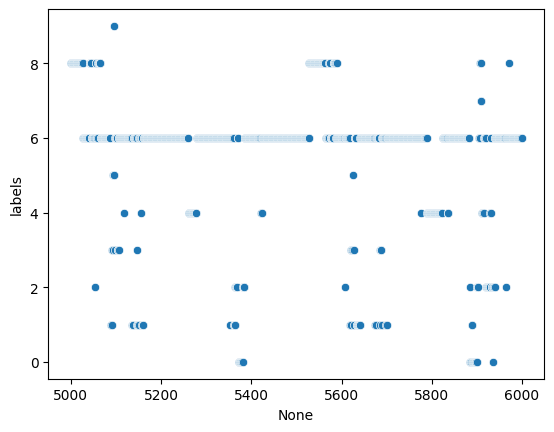

In [19]:
sns.scatterplot(x = df_agg.index, y = df_agg['labels'])

#### Time series scatter plot of the subset data color coded by the label given by the agglomerative clustering algorithm.

<Axes: xlabel='None', ylabel='Acc_X_lf'>

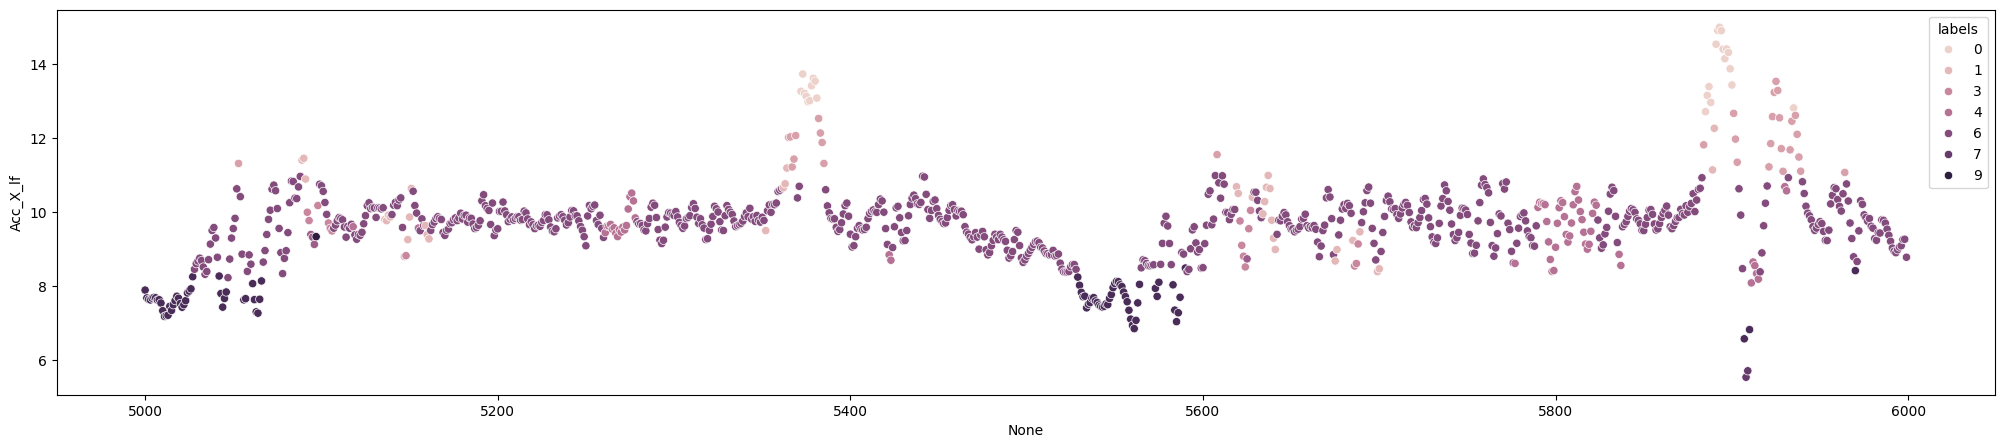

In [20]:
plt.figure(figsize = (25, 5))
sns.scatterplot(x = df_agg.index, y = df_agg['Acc_X_lf'], hue = df_agg['labels'])

<Axes: xlabel='None', ylabel='Acc_X_rf'>

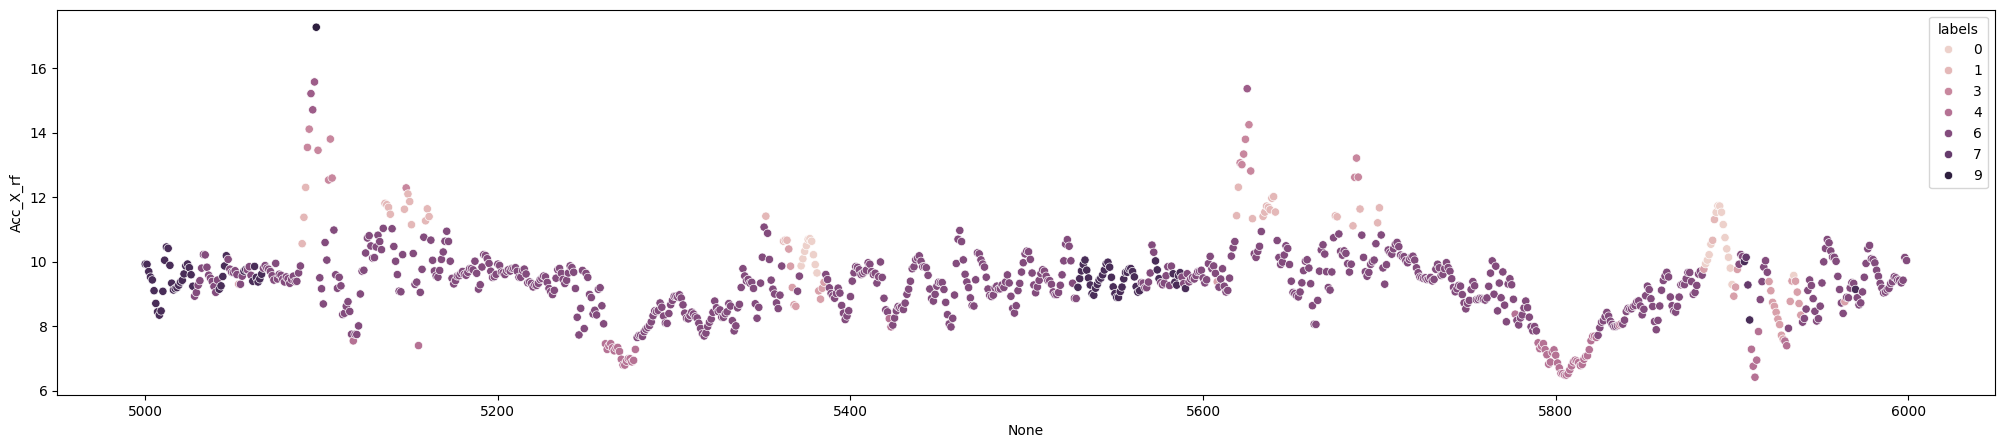

In [21]:
plt.figure(figsize = (25, 5))
sns.scatterplot(x = df_agg.index, y = df_agg['Acc_X_rf'], hue = df_agg['labels'])

Since we are considering two features when performing clustering, we have to consider distance in both features. Then, if two points are close in one feature but far in another feature, and being clustered into the same cluster, the cluster may not seem to make sense from the perspective of the feature where they are relatively far apart. Hence, these color-coded plots display some sense, but not completely yet.

#### Work in process...

In [22]:
def plot_dendrogram(df):
  scaler = StandardScaler()
  scaler.fit(df)
  scaled_df = pd.DataFrame(scaler.transform(df))

  pca = PCA(n_components=scaled_df.shape[1], random_state=0)
  pca.fit(scaled_df)
  pca_df = pd.DataFrame(pca.transform(scaled_df))

  c_max, idx_max = find_clustering(pca_df)

  z = linkage(pca_df, metric = idx_max[0], method = idx_max[1])
  plt.figure(figsize = (25, 5))
  dendrogram(z);

  return pca_df, idx_max

In [23]:
def fit_agg_model(df, n_cluster, idx, pca, column):
  model_agg = AgglomerativeClustering(n_clusters = n_cluster, metric = idx[0], linkage = idx[1])
  model_agg.fit(pca)

  df_labeled = df.copy()
  df_labeled['labels'] = model_agg.labels_
  profile_agg = df_labeled.groupby('labels').mean()
  profile_agg['count'] = df_labeled.groupby('labels')[column].count().values

  columns = df_labeled.columns[:-1]

  fig, axes = plt.subplots(1, len(columns), figsize=(25, 5))

  for i, column in enumerate(columns):
      sns.scatterplot(x=df_labeled.index, y=df_labeled[column], hue=df_labeled['labels'], ax=axes[i])
      axes[i].set_title(f"Scatter plot of {column}")
      axes[i].set_xlabel('Index')
      axes[i].set_ylabel(column)
  plt.tight_layout()
  plt.show()
  return model_agg, profile_agg

0.6989505732110252
0.6245115059329717
0.8246889625267091
0.6999041500650605
0.7097155828441433
0.806005336237689
0.6856720284714132
0.4530141529896314
0.7667801101320225
c_max: 0.8246889625267091
idx_max: ('euclidean', 'average')


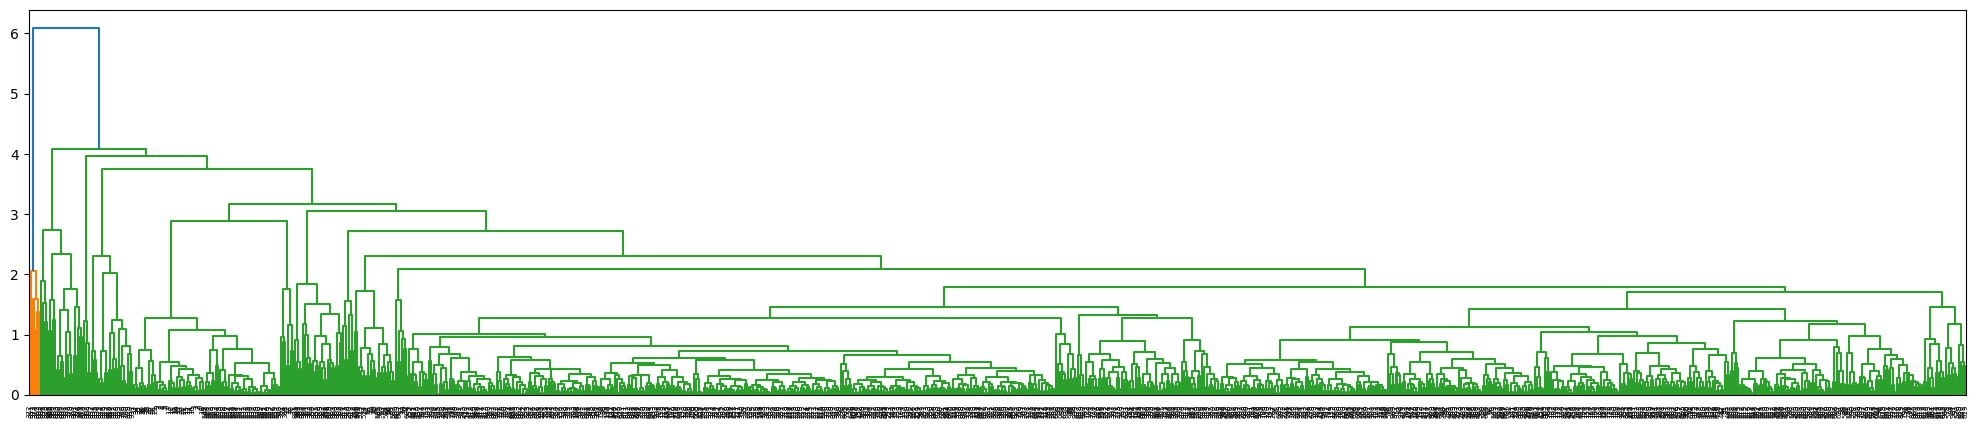

In [24]:
pca_df, idx_max = plot_dendrogram(data.iloc[5000:6000, 0:3])

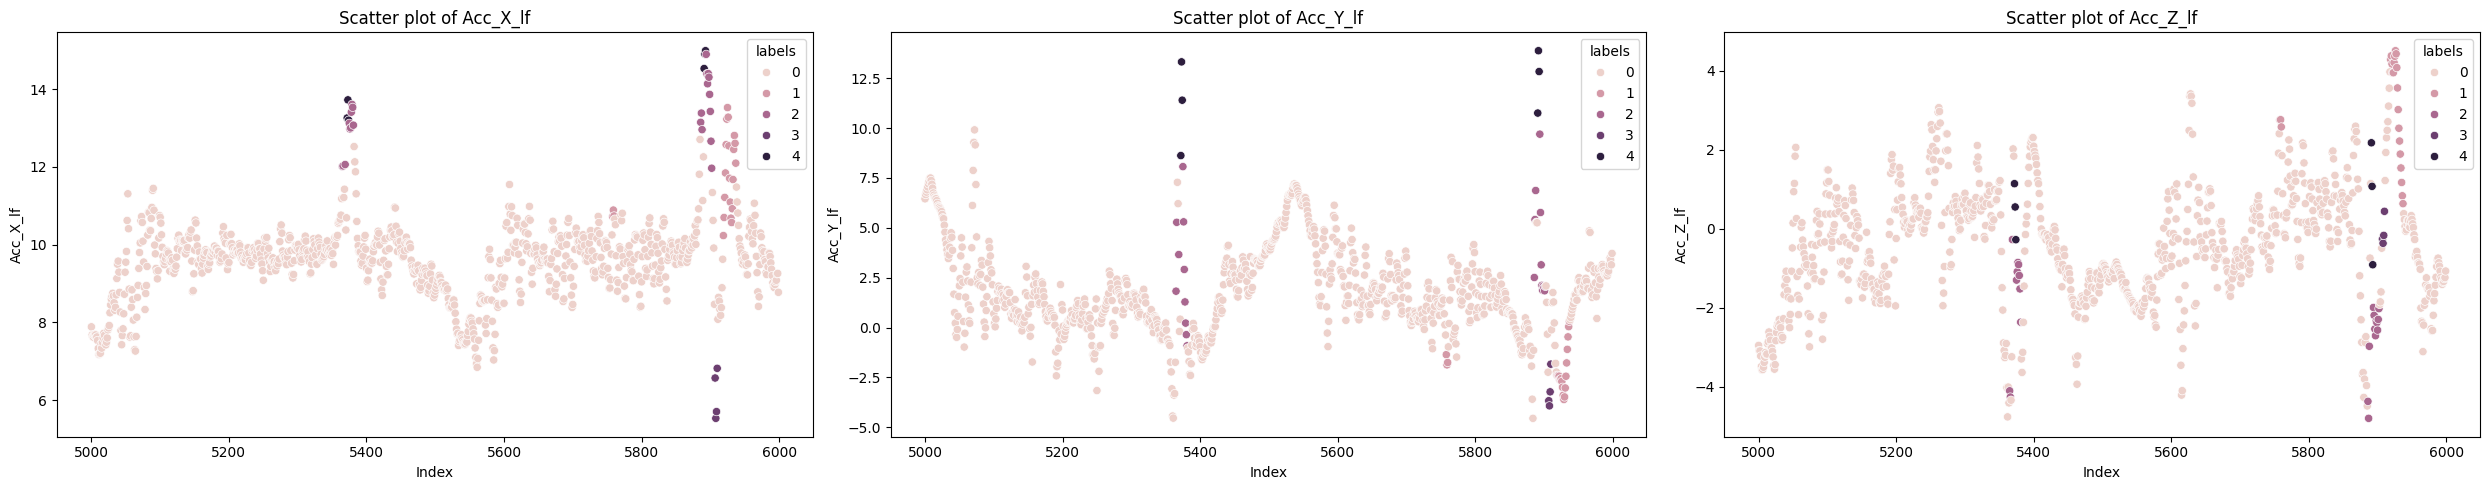

In [25]:
model_agg, profile_agg = fit_agg_model(data.iloc[5000:6000, 0:3], 5, idx_max, pca_df, 'Acc_X_lf')